In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import os


2022-11-13 14:12:49.120596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 14:12:49.659618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-11-13 14:12:49.659653: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-13 14:12:49.762221: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-13 14:12:51.541063: W 

In [3]:

# set up dataset from triple_mnist/train directory
train_ds = tf.data.Dataset.list_files('triple_mnist/train/*/*')
test_ds = tf.data.Dataset.list_files('triple_mnist/test/*/*')
val_ds = tf.data.Dataset.list_files('triple_mnist/val/*/*')


def process_path(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # for part in parts:

    number = parts[-2]
    number = tf.strings.to_number(number, out_type=tf.int32)
    # get digits of this number
    digits = [number // 100, (number // 10) % 10, number % 10]

    # # encode each digit as a one-hot vector and merge them into a single vector
    # digits = [tf.one_hot(digit, 10) for digit in digits]
    # digits = tf.concat(digits, axis=0)

    # # convert digits to tensor type
    # digits = tf.cast(digits, tf.float32)
    # # reshape digits to (30,)
    # digits = tf.reshape(digits, (-1, 30,))
    digits = tf.reshape(digits, (-1, 3,))

    # print raw value for parts as string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img)
    # flatten image
    # img = tf.reshape(img, (-1, 7056,))
    # transpose image
    return img, digits


train_ds = train_ds.map(
    process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(
    process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(
    process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)


2022-11-13 14:12:54.869476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 14:12:54.870140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-11-13 14:12:54.870345: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib
2022-11-13 14:12:54.870515: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: 

Image shape:  (84, 84, 1)
Label:  [[3 2 8]]
label shape:  (1, 3)
Number:  [[3 2 8]]


/home/leo/.local/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


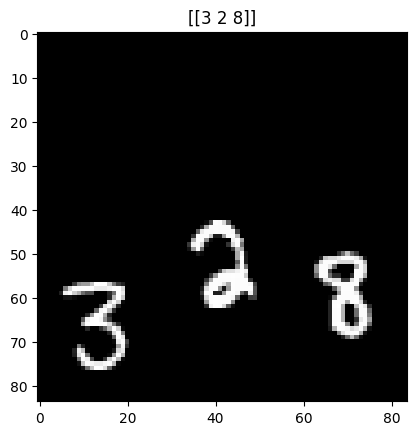

In [4]:

image, label = next(iter(train_ds))
print("Image shape: ", image.numpy().shape)
print("Label: ", label.numpy())

# convert label into 3digit number
label = label.numpy()
print("label shape: ", label.shape)
# get inidices of 1s in each digit

print("Number: ", label)
plt.title(label)

# show image
image = image.numpy()
image = np.reshape(image, (84, 84))
plt.imshow(image, cmap='gray')


In [10]:
# copy model from first assignment
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten, Dropout

ann = keras.Sequential(
    [
        Conv2D(filters=32, kernel_size=(2, 2), activation='relu',
               padding="Same", input_shape=(84, 84, 1)),
        Conv2D(filters=32, kernel_size=(2, 2), activation='relu',
               padding="Same"),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
               padding="Same"),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu',
               padding="Same"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Dropout(0.25),
        Flatten(),
       #  Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ]
)


In [11]:
from keras.optimizers import RMSprop

# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

# Compile the model
ann.compile(optimizer=optimizer,
            loss="categorical_crossentropy", metrics=["accuracy"])
ann.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 84, 84, 32)        160       
                                                                 
 conv2d_9 (Conv2D)           (None, 84, 84, 32)        4128      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 42, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 42, 42, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 42, 42, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 21, 21, 64)       0         
 2D)                                                  

In [12]:
# Set a learning rate annealer
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
epochs = 30  # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86
history = ann.fit(train_ds,
                  batch_size=batch_size, epochs=epochs, validation_data=val_ds, callbacks=[learning_rate_reduction])


Epoch 1/30
 4540/64000 [=>............................] - ETA: 11:05 - loss: 0.0000e+00 - accuracy: 0.0000e+00

KeyboardInterrupt: 